In [1]:
import pandas as pd
import sys
import os
from imblearn.over_sampling import SMOTE
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
from category_encoders import TargetEncoder
import lightgbm as lgb
from sklearn.model_selection import cross_val_score, StratifiedKFold
from sklearn.metrics import f1_score, recall_score, precision_score, confusion_matrix, make_scorer
import optuna
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report

warnings.filterwarnings('ignore')
sys.path.append(os.path.abspath("../Sources"))
pd.set_option('display.max_columns', None) 

In [2]:
train = pd.read_csv('..\Datasets\Copy of churn-bigml-80.csv')
test = pd.read_csv('..\Datasets\Copy of churn-bigml-20.csv')

In [3]:
from preprocessing import preprocess_pipeline

In [4]:
X_train, y_train, X_test, y_test = preprocess_pipeline(train, test, model='rf')

In [5]:
f1_scorer = make_scorer(f1_score, average='macro')
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

model = RandomForestClassifier(random_state=42)
scores = cross_val_score(model, X_train, y_train, cv=cv, scoring=f1_scorer)

print("F1 scores on each fold:", scores)
print("Mean F1 score:", scores.mean())

F1 scores on each fold: [0.95060082 0.95716017 0.95495196 0.96376489 0.95716017]
Mean F1 score: 0.9567276010016886


In [6]:
def objective(trial):
    params = {
        'n_estimators': trial.suggest_int('n_estimators', 50, 500),
        'max_depth': trial.suggest_int('max_depth', 5, 30),
        'min_samples_split': trial.suggest_int('min_samples_split', 2, 20),
        'min_samples_leaf': trial.suggest_int('min_samples_leaf', 1, 20),
        'max_features': trial.suggest_categorical('max_features', ['sqrt', 'log2']),
        'bootstrap': trial.suggest_categorical('bootstrap', [True, False]),
        'random_state': 42
    }

    model = RandomForestClassifier(**params)
    score = cross_val_score(model, X_train, y_train, scoring=f1_scorer, cv=cv, n_jobs=-1).mean()
    return score

study = optuna.create_study(direction='maximize')
study.optimize(objective, n_trials=50)

print("Best trial:")
print(study.best_trial)
print("Best parameters:", study.best_params)


[I 2025-05-18 23:23:00,063] A new study created in memory with name: no-name-34795e30-ce6b-4881-b7dd-1ef5753fed85
[I 2025-05-18 23:23:06,172] Trial 0 finished with value: 0.893180311505503 and parameters: {'n_estimators': 244, 'max_depth': 11, 'min_samples_split': 10, 'min_samples_leaf': 20, 'max_features': 'sqrt', 'bootstrap': True}. Best is trial 0 with value: 0.893180311505503.
[I 2025-05-18 23:23:12,579] Trial 1 finished with value: 0.9098349181871977 and parameters: {'n_estimators': 221, 'max_depth': 10, 'min_samples_split': 16, 'min_samples_leaf': 17, 'max_features': 'sqrt', 'bootstrap': False}. Best is trial 1 with value: 0.9098349181871977.
[I 2025-05-18 23:23:15,714] Trial 2 finished with value: 0.9300227090505114 and parameters: {'n_estimators': 56, 'max_depth': 20, 'min_samples_split': 17, 'min_samples_leaf': 11, 'max_features': 'sqrt', 'bootstrap': False}. Best is trial 2 with value: 0.9300227090505114.
[I 2025-05-18 23:23:19,267] Trial 3 finished with value: 0.928468605982

Best trial:
FrozenTrial(number=45, state=1, values=[0.963986099641249], datetime_start=datetime.datetime(2025, 5, 18, 23, 27, 27, 576215), datetime_complete=datetime.datetime(2025, 5, 18, 23, 27, 34, 702022), params={'n_estimators': 244, 'max_depth': 25, 'min_samples_split': 4, 'min_samples_leaf': 1, 'max_features': 'sqrt', 'bootstrap': False}, user_attrs={}, system_attrs={}, intermediate_values={}, distributions={'n_estimators': IntDistribution(high=500, log=False, low=50, step=1), 'max_depth': IntDistribution(high=30, log=False, low=5, step=1), 'min_samples_split': IntDistribution(high=20, log=False, low=2, step=1), 'min_samples_leaf': IntDistribution(high=20, log=False, low=1, step=1), 'max_features': CategoricalDistribution(choices=('sqrt', 'log2')), 'bootstrap': CategoricalDistribution(choices=(True, False))}, trial_id=45, value=None)
Best parameters: {'n_estimators': 244, 'max_depth': 25, 'min_samples_split': 4, 'min_samples_leaf': 1, 'max_features': 'sqrt', 'bootstrap': False}


Classification Report:

              precision    recall  f1-score   support

           0     0.9660    0.9930    0.9793       572
           1     0.9494    0.7895    0.8621        95

    accuracy                         0.9640       667
   macro avg     0.9577    0.8912    0.9207       667
weighted avg     0.9636    0.9640    0.9626       667



<Axes: >

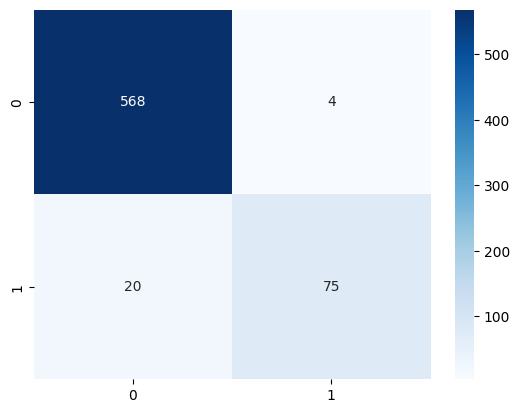

In [7]:
best_model = RandomForestClassifier(**study.best_params)
best_model.fit(X_train, y_train)

y_pred = best_model.predict(X_test)

print("Classification Report:\n")
print(classification_report(y_test, y_pred, digits=4))
sns.heatmap(confusion_matrix(y_test, y_pred), annot=True, fmt='d', cmap='Blues')

In [8]:
importances = best_model.feature_importances_
feature_names = X_train.columns

importance_df = pd.DataFrame({
    'Feature': feature_names,
    'Importance': importances
}).sort_values(by='Importance', ascending=False)

print(importance_df.head(10))

                   Feature  Importance
29            Total charge    0.135517
17  Customer service calls    0.098778
5        Total day minutes    0.064724
22           total_minutes    0.055996
7         Total day charge    0.047486
4    Number vmail messages    0.047263
21  avg_intl_call_duration    0.046089
3          Voice mail plan    0.046019
1                Area code    0.028836
30              State_freq    0.026259


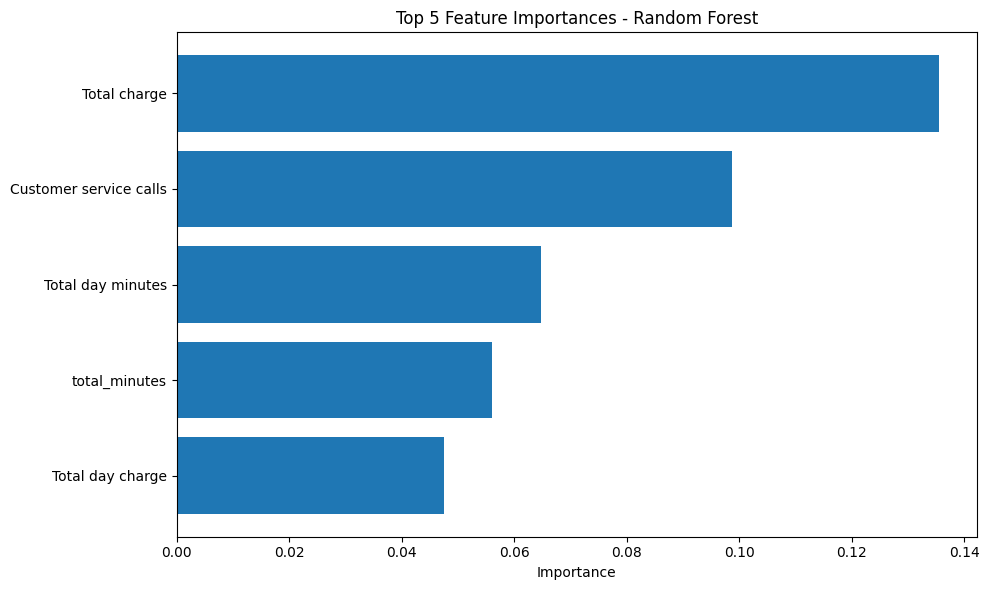

In [9]:
plt.figure(figsize=(10, 6))
plt.barh(importance_df['Feature'][:5][::-1], importance_df['Importance'][:5][::-1])
plt.xlabel("Importance")
plt.title("Top 5 Feature Importances - Random Forest")
plt.tight_layout()
plt.show()